In [1]:
%matplotlib inline

### os
import os
import sys

### datetimes
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import dask
from dask.diagnostics import ProgressBar
from tqdm import tqdm

### plotting
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd()

### import local functions for the processing of the C3S forecasts 

In [3]:
sys.path.append('../..')

In [4]:
from ICU_Water_Watch import C3S, domains, geo, utils

### parameters for papermill

In [5]:
provider = 'CDS'
varname = 'tprate'
period = 'seasonal'
GCM = 'ECMWF'
quantiles = 'tercile'
country = "Nauru"
admin = "Nauru"
lag = 0
method = 'empirical'

In [6]:
# Parameters
country = "Marshall Islands"
admin = "Northern Marshall Islands"
GCM = "ECCC_GEM_NEMO"
method = "empirical"


### read the administrative boundaries 

In [7]:
coastlines_dpath = pathlib.Path('/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/Admin_boundaries/Coastlines')

In [8]:
shapefile = gpd.read_file(coastlines_dpath.joinpath('ICU_admin_geometries0_360.shp'))

In [9]:
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
shapefile.columns

Index(['id', 'Country', 'Admin_boun', 'geometry'], dtype='object')

In [11]:
country_col = 'Country'
admin_col = 'Admin_boun'

In [12]:
shapefile.loc[:,f"{admin_col}"] = shapefile.loc[:,f"{admin_col}"].str.replace("'","")

In [13]:
countries = shapefile.loc[:,'Country'].unique()

In [14]:
# for country in countries: 
#     sub = shapefile.query(f"{country_col} == '{country}'")
#     for admin in sub.loc[:,f"{admin_col}"].unique(): 
#         print(f"{country}, {admin}")

### list of GCMs 

In [15]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC_CanCM4i', 'ECCC_GEM_NEMO']

### get today's date 

In [16]:
date = datetime.utcnow()

### apply lag 

In [17]:
date = date - relativedelta(months=lag)

In [18]:
print(f"will process forecasts issued in {date:%B %Y}")

will process forecasts issued in November 2021


### path to the GCMs **hindcast datasets** and **climatologies** 

In [19]:
gcm_path = pathlib.Path(f'/media/nicolasf/END19101/ICU/data/{provider}/operational/hindcasts')

### path to where the **realtime forecasts** have been downloaded 

In [20]:
forecasts_path = pathlib.Path(f'/media/nicolasf/END19101/ICU/data/{provider}/operational/forecasts')

In [21]:
forecasts_path

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/operational/forecasts')

### output path for the probabilistic forecast files 

In [22]:
opath = CWD.parents[1].joinpath("outputs/C3S")

In [23]:
if not opath.exists(): 
    opath.mkdir(parents=True)

### get year and month 

In [24]:
year, month =  date.year, date.month

### reads the forecasts 

In [25]:
print(f"{50*'-'}\nReading forecasts issued {year}-{str(month).zfill(2)} for GCM {GCM}")

if 'ECCC' in GCM: 

    x = xr.open_dataset(forecasts_path.joinpath(f"{GCM}/{varname.upper()}/ensemble_seas_forecasts_{varname}_from_{year}_{str(month).zfill(2)}_ECCC.netcdf"), engine='netcdf4')

else: 
    
    x = xr.open_dataset(forecasts_path.joinpath(f"{GCM}/{varname.upper()}/ensemble_seas_forecasts_{varname}_from_{year}_{str(month).zfill(2)}_{GCM}.netcdf"), engine='netcdf4')


### preprocess (harmonize the variable names, sort the latitudes, etc )

x = C3S.preprocess_GCM(x)

### convert from mm/day to mm/month 

x = C3S.convert_rainfall(x, varin='tprate', varout='precip', leadvar='step', timevar='time', dropvar=True)

### just in case, remove potential missing fields (members)

x = x.dropna(dim='member')

--------------------------------------------------
Reading forecasts issued 2021-11 for GCM ECCC_GEM_NEMO

unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip


In [26]:
x

<xarray.Dataset>
Dimensions:  (time: 1, lon: 121, lat: 81, member: 10, step: 5)
Coordinates:
  * time     (time) datetime64[ns] 2021-11-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 -46.0 ... 27.0 28.0 29.0 30.0
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9
  * step     (step) int64 1 2 3 4 5
Data variables:
    precip   (time, step, member, lat, lon) float64 65.68 69.5 ... 3.546 4.039
Attributes:
    Conventions:  CF-1.6
    history:      2021-11-15 22:46:04 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [27]:
if period == 'seasonal': 
    
    x = x.rolling({'step':3}, min_periods=3).sum('step')
    
    x = x.sel({'step':slice(3, None)})

### restrict to country 

In [28]:
sub = shapefile.query(f"Country == '{country}'")

In [29]:
shape = sub.query(f"{admin_col} == '{admin}'")

<AxesSubplot:>

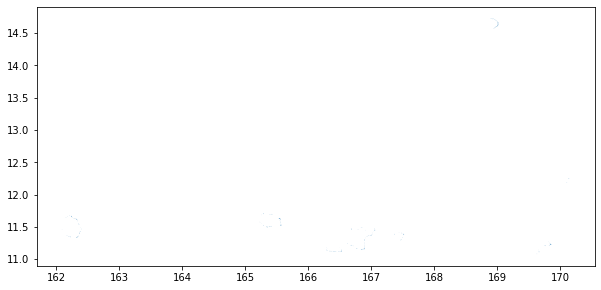

In [30]:
shape.plot(figsize=(10,10))

In [31]:
original_shape = shape.copy()

### for Island groups consituted of very small islands / atolls, we don't filter OUT the geometries, we actually buffer them  so that they can match the resolution of the GCM (once interpolated)

In [32]:
float(shape.to_crs('EPSG:3857').area / 10**6)

55.8698401030706

In [33]:
shape = shape.buffer(0.25)

In [34]:
# if float(shape.to_crs('EPSG:3857').area / 10**6) < 2000: 
#     shape = shape.buffer(0.25)
# else: 
#     shape = geo.filter_by_area(shape, min_area=500)

<AxesSubplot:>

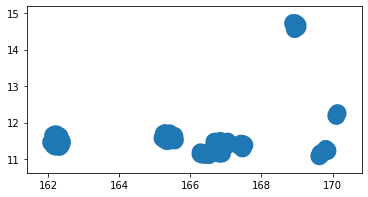

In [35]:
shape.plot()

In [36]:
x, domain = geo.mask_dataset(x, shape, coastline_buffer=15)

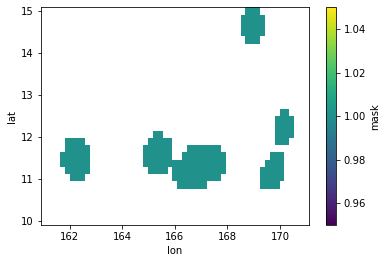

In [37]:
x['mask'].plot()

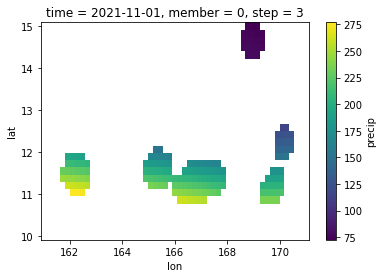

In [38]:
x['precip'].squeeze()[0,0,:,:].plot()

### calculate the average 

In [39]:
x_regional = x.mean(dim=['lat','lon'])

In [40]:
x_regional

<xarray.Dataset>
Dimensions:  (time: 1, member: 10, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 2021-11-01
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9
  * step     (step) int64 3 4 5
Data variables:
    precip   (time, step, member) float64 186.6 221.6 302.7 ... 438.3 272.4
    mask     float64 1.0

### reads the climatology 

In [41]:
dpath_clim = pathlib.Path('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/ICU_validation/admin/climatologies') 

In [42]:
dpath_clim

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/ICU_validation/admin/climatologies')

In [43]:
varname

'tprate'

### list the list of files for the country and admin area, length should be only one 

In [44]:
lfiles_clim = list(dpath_clim.glob(f"{method}_tercile_{varname}_{period}_{GCM}_{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}*.nc"))

In [45]:
lfiles_clim

[PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/ICU_validation/admin/climatologies/empirical_tercile_tprate_seasonal_ECCC_GEM_NEMO_Marshall_Islands_Northern_Marshall_Islands.nc')]

In [46]:
if len(lfiles_clim) == 1: 
    fname_clim = lfiles_clim[0]

In [47]:
clim = xr.open_dataset(fname_clim)

In [48]:
clim

<xarray.Dataset>
Dimensions:   (step: 3, month: 7, quantile: 2)
Coordinates:
  * step      (step) int64 3 4 5
  * quantile  (quantile) float64 0.3333 0.6666
  * month     (month) int64 5 6 7 8 9 10 11
Data variables:
    precip    (month, quantile, step) float64 ...
    mask      (month, quantile) float64 ...

In [49]:
dset_cat = C3S.get_GCM_category_digitize(x_regional, clim.sel(month=month), varname='precip', dim='quantile')

In [50]:
dset_cat

<xarray.Dataset>
Dimensions:  (time: 1, member: 10, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 2021-11-01
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9
  * step     (step) int64 3 4 5
    month    int64 11
Data variables:
    precip   (time, step, member) int64 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3

In [51]:
quantiles_category_percent = C3S.calculate_quantiles_probabilities(dset_cat, ncategories=3)

In [52]:
quantiles_category_percent

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 1, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 2021-11-01
  * step     (step) int64 3 4 5
    month    int64 11
  * tercile  (tercile) int64 1 2 3
Data variables:
    precip   (tercile, time, step) float64 0.0 0.0 0.0 0.0 ... 100.0 100.0 100.0

### because of numerical approximations, sometimes the sum over the quantile dimension is not strictly equal to 100.

In [53]:
np.alltrue((quantiles_category_percent.sum('tercile')['precip'] == 100.))

<xarray.DataArray 'precip' ()>
array(True)
Coordinates:
    month    int64 11

### but it is close enough 

In [54]:
np.alltrue((quantiles_category_percent.sum('tercile')['precip'] >= 99.9999))

<xarray.DataArray 'precip' ()>
array(True)
Coordinates:
    month    int64 11

In [55]:
np.alltrue((quantiles_category_percent.sum('tercile')['precip'] <= 100.0001))

<xarray.DataArray 'precip' ()>
array(True)
Coordinates:
    month    int64 11

In [56]:
quantiles_category_percent.step

<xarray.DataArray 'step' (step: 3)>
array([3, 4, 5])
Coordinates:
  * step     (step) int64 3 4 5
    month    int64 11

### transform the xarray dataset into a pandas dataframe with multiindex columns (product of leadtimes and quantiles)

In [57]:
df_quantile_probabilities = []

for step in quantiles_category_percent.step.data: 
    
    df = quantiles_category_percent.sel(step=step)['precip'].to_pandas().T
    
    cols = pd.MultiIndex.from_product([[step], df.columns]) 

    df.columns = cols 
    
    df_quantile_probabilities.append(df)


In [58]:
df_quantile_probabilities = pd.concat(df_quantile_probabilities, axis=1) 

In [59]:
df_quantile_probabilities.head()

3                4                5            
tercile       1    2      3    1    2      3    1    2      3
time                                                         
2021-11-01  0.0  0.0  100.0  0.0  0.0  100.0  0.0  0.0  100.0

In [60]:
df_quantile_probabilities.index[0].to_pydatetime()

datetime.datetime(2021, 11, 1, 0, 0)

In [61]:
df_quantile_probabilities.index = pd.MultiIndex.from_tuples([(df_quantile_probabilities.index[0].to_pydatetime(),country, admin, GCM)])

In [62]:
df_quantile_probabilities.index.name = ''

In [63]:
df_quantile_probabilities

3       \
tercile                                                                1    2   
2021-11-01 Marshall Islands Northern Marshall Islands ECCC_GEM_NEMO  0.0  0.0   

                                                                            \
tercile                                                                  3   
2021-11-01 Marshall Islands Northern Marshall Islands ECCC_GEM_NEMO  100.0   

                                                                       4       \
tercile                                                                1    2   
2021-11-01 Marshall Islands Northern Marshall Islands ECCC_GEM_NEMO  0.0  0.0   

                                                                            \
tercile                                                                  3   
2021-11-01 Marshall Islands Northern Marshall Islands ECCC_GEM_NEMO  100.0   

                                                                       5       \
tercile                                                                1    2   
2021-11-01 Marshall Islands Northern Marshall Islands ECCC_GEM_NEMO  0.0  0.0   

                                                                            
tercile                                                                  3  
2021-11-01 Marshall Islands Northern Marshall Islands ECCC_GEM_NEMO  100.0

### saves to disk 

In [64]:
year

2021

In [65]:
opath = opath.joinpath(f'admin/{quantiles}')

In [66]:
if not opath.exists(): 
    opath.mkdir(parents=True)

In [67]:
df_quantile_probabilities.to_csv(opath.joinpath(f"{quantiles}_probs_forecasts_from_{year}_{str(month).zfill(2)}_{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}_{GCM}.csv"))

In [68]:
x.close()

In [69]:
opath

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S/admin/tercile')